### Running Instructions

1. The sections labeled (skippable) can be skipped because they produce the already saved files. If you would like to re-run them, please change the `input_directory` variable in the cell below to match where the data can be found.



In [ ]:
input_directory = '/kaggle/input/CORD-19-research-challenge/'

# NLP Project Submission

## Task Details: What do we know about COVID-19 risk factors?

What do we know about COVID-19 risk factors? What have we learned from epidemiological studies?

Specifically, we want to know what the literature reports about:

* Data on potential risks factors
 * Smoking, pre-existing pulmonary disease
 * Co-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities
 * Neonates and pregnant women
 * Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences.
* Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors
* Severity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups
* Susceptibility of populations
* Public health mitigation measures that could be effective for control

## Basic Imports

In [ ]:
# Installs
!pip install ipython-autotime
!pip install langdetect
!pip install -U nltk==3.4

import numpy as np
import pandas as pd
import os
import glob
import json
import nltk
import matplotlib.pyplot as plt

# Downloads #
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
#############

from nltk.corpus import stopwords
from wordcloud import WordCloud
from tqdm import tqdm
from ast import literal_eval
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE
from langdetect import detect as detect_language
from IPython.display import display, HTML

tqdm.pandas()

Requirement already up-to-date: nltk==3.4 in /usr/local/lib/python3.6/dist-packages (3.4)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Common Tools

Here we define some useful functions and tools that are needed later.

### Stopwords

This method creates a set of stopwords by combinging the basic NLTK set with the Mysql set and adding a few words that are mostly related to authorship and copyright.

In [ ]:
def get_expanded_stopwords_set():
    # https://dev.mysql.com/doc/refman/5.7/en/fulltext-stopwords.html#fulltext-stopwords-stopwords-for-myisam-search-indexes
    extra_stopwords = ["a's" , "able" , "about" , "above" , "according" , "accordingly" , "across" , "actually" , "after" , "afterwards" , "again" , "against" , "ain't" , "al", "all" , "allow" , "allows" , "almost" , "alone" , "along" , "already" , "also" , "although" , "always" , "am" , "among" , "amongst" , "an" , "and" , "another" , "any" , "anybody" , "anyhow" , "anyone" , "anything" , "anyway" , "anyways" , "anywhere" , "apart" , "appear" , "appreciate" , "appropriate" , "are" , "aren't" , "around" , "as" , "aside" , "ask" , "asking" , "associated" , "at" , "available" , "away" , "awfully" , "be" , "became" , "because" , "become" , "becomes" , "becoming" , "been" , "before" , "beforehand" , "behind" , "being" , "believe" , "below" , "beside" , "besides" , "best" , "better" , "between" , "beyond" , "both" , "brief" , "but" , "by" , "c'mon" , "c's" , "came" , "can" , "can't" , "cannot" , "cant" , "cause" , "causes" , "certain" , "certainly" , "changes" , "clearly" , "co" , "com" , "come" , "comes" , "concerning" , "consequently" , "consider" , "considering" , "contain" , "containing" , "contains" , "corresponding" , "could" , "couldn't" , "course" , "currently" , "definitely" , "described" , "despite" , "did" , "didn't" , "different" , "do" , "does" , "doesn't" , "doing" , "don't" , "done" , "down" , "downwards" , "during" , "each" , "edu" , "eg" , "eight" , "either" , "else" , "elsewhere" , "enough" , "entirely" , "especially" , "et" , "etc" , "even" , "ever" , "every" , "everybody" , "everyone" , "everything" , "everywhere" , "ex" , "exactly" , "example" , "except" , "far" , "few" , "fifth" , "first" , "five" , "followed" , "following" , "follows" , "for" , "former" , "formerly" , "forth" , "four" , "from" , "further" , "furthermore" , "get" , "gets" , "getting" , "given" , "gives" , "go" , "goes" , "going" , "gone" , "got" , "gotten" , "greetings" , "had" , "hadn't" , "happens" , "hardly" , "has" , "hasn't" , "have" , "haven't" , "having" , "he" , "he's" , "hello" , "help" , "hence" , "her" , "here" , "here's" , "hereafter" , "hereby" , "herein" , "hereupon" , "hers" , "herself" , "hi" , "him" , "himself" , "his" , "hither" , "hopefully" , "how" , "howbeit" , "however" , "i'd" , "i'll" , "i'm" , "i've" , "ie" , "if" , "ignored" , "immediate" , "in" , "inasmuch" , "inc" , "indeed" , "indicate" , "indicated" , "indicates" , "inner" , "insofar" , "instead" , "into" , "inward" , "is" , "isn't" , "it" , "it'd" , "it'll" , "it's" , "its" , "itself" , "just" , "keep" , "keeps" , "kept" , "know" , "known" , "knows" , "last" , "lately" , "later" , "latter" , "latterly" , "least" , "less" , "lest" , "let" , "let's" , "like" , "liked" , "likely" , "little" , "look" , "looking" , "looks" , "ltd" , "mainly" , "many" , "may" , "maybe" , "me" , "mean" , "meanwhile" , "merely" , "might" , "more" , "moreover" , "most" , "mostly" , "much" , "must" , "my" , "myself" , "name" , "namely" , "nd" , "near" , "nearly" , "necessary" , "need" , "needs" , "neither" , "never" , "nevertheless" , "new" , "next" , "nine" , "no" , "nobody" , "non" , "none" , "noone" , "nor" , "normally" , "not" , "nothing" , "now" , "nowhere" , "obviously" , "of" , "off" , "often" , "oh" , "ok" , "okay" , "old" , "on" , "once" , "one" , "ones" , "only" , "onto" , "or" , "other" , "others" , "otherwise" , "ought" , "our" , "ours" , "ourselves" , "out" , "outside" , "over" , "overall" , "own" , "particular" , "particularly" , "per" , "perhaps" , "placed" , "please" , "plus" , "possible" , "presumably" , "probably" , "provides" , "que" , "quite" , "qv" , "rather" , "rd" , "re" , "really" , "reasonably" , "regarding" , "regardless" , "regards" , "relatively" , "respectively" , "right" , "said" , "same" , "saw" , "say" , "saying" , "says" , "second" , "secondly" , "see" , "seeing" , "seem" , "seemed" , "seeming" , "seems" , "seen" , "self" , "selves" , "sensible" , "sent" , "serious" , "seriously" , "seven" , "several" , "shall" , "she" , "should" , "shouldn't" , "since" , "six" , "so" , "some" , "somebody" , "somehow" , "someone" , "something" , "sometime" , "sometimes" , "somewhat" , "somewhere" , "soon" , "sorry" , "specified" , "specify" , "specifying" , "still" , "sub" , "such" , "sup" , "sure" , "t's" , "take" , "taken" , "tell" , "tends" , "th" , "than" , "thank" , "thanks" , "thanx" , "that" , "that's" , "thats" , "the" , "their" , "theirs" , "them" , "themselves" , "then" , "thence" , "there" , "there's" , "thereafter" , "thereby" , "therefore" , "therein" , "theres" , "thereupon" , "these" , "they" , "they'd" , "they'll" , "they're" , "they've" , "think" , "third" , "this" , "thorough" , "thoroughly" , "those" , "though" , "three" , "through" , "throughout" , "thru" , "thus" , "to" , "together" , "too" , "took" , "toward" , "towards" , "tried" , "tries" , "truly" , "try" , "trying" , "twice" , "two" , "un" , "under" , "unfortunately" , "unless" , "unlikely" , "until" , "unto" , "up" , "upon" , "us" , "use" , "used" , "useful" , "uses" , "using" , "usually" , "value" , "various" , "very" , "via" , "viz" , "vs" , "want" , "wants" , "was" , "wasn't" , "way" , "we" , "we'd" , "we'll" , "we're" , "we've" , "welcome" , "well" , "went" , "were" , "weren't" , "what" , "what's" , "whatever" , "when" , "whence" , "whenever" , "where" , "where's" , "whereafter" , "whereas" , "whereby" , "wherein" , "whereupon" , "wherever" , "whether" , "which" , "while" , "whither" , "who" , "who's" , "whoever" , "whole" , "whom" , "whose" , "why" , "will" , "willing" , "wish" , "with" , "within" , "without" , "won't" , "wonder" , "would" , "wouldn't" , "yes" , "yet" , "you" , "you'd" , "you'll" , "you're" , "you've" , "your" , "yours" , "yourself" , "yourselves" , "zero"]

    experimental_stopwords = ["due", "arxiv", "biorxiv", "medrxiv", "license", "doi", "copyright", "author", "funder", "preprint", "figure", "http", "https", "cc", "org", "table"]

    original_stopwords = set(stopwords.words('english'))

    original_stopwords = original_stopwords.union(set(experimental_stopwords))

    expanded_stopwords_set = original_stopwords.union(set(extra_stopwords))

    print('Expanded Set: ', expanded_stopwords_set)

    return expanded_stopwords_set

expanded_stopwords_set = get_expanded_stopwords_set()

Expanded Set:  {'funder', 'each', 'me', 'their', 'more', 'anybody', 'biorxiv', 'until', 'causes', 'haven', 'besides', 'far', 'an', 'following', 'only', 'always', 'looking', "needn't", 'hereby', 'seeming', 'a', 'looks', 'apart', 'merely', 'ie', 'few', "they're", 'over', 'name', 'really', 'seeing', 'immediate', 'doi', 'especially', 'won', 'otherwise', 'everywhere', 'into', 'rather', 'soon', 'want', "wouldn't", "hadn't", 'some', 'most', 'after', 'is', 'below', 'self', 'at', 'it', 'herein', 'clearly', 'license', 're', 'once', 'seemed', 'possible', 'except', 'll', 'having', "wasn't", 'seven', "doesn't", 'her', 'noone', 'best', 'nearly', 'however', 'neither', 'doesn', 'saw', 'anyways', 'comes', 'regards', 'several', 'didn', 'near', 'third', "we'll", "here's", "they've", 'ever', 'within', 'nevertheless', 'regarding', 'thanx', 'gone', 'seen', 'hasn', 'were', 'going', 'brief', 'sometimes', 'contains', 'know', 'herself', 'ok', 'placed', 'way', 'because', 'or', 'i', 'him', 'y', 'without', 'right'

We also create another set that includes some generic verbs and nouns. This set will be used for visualizations, such as word clouds.

In [ ]:
clustering_specific_stopwords = set(
    [
     'result', 'results', 'resulting', 'show', 'shown', 'shows', 'showed', 
     'including', 'include', 'study', 'mg', 'kg', 'report', 'reported', 'reports', 
     'find', 'found', 'due', 'observe', 'observed', 'provide', 'provided', 
     'specific', 'similar', 'different', 'same', 'addition', 'add', 'form', 
     'occur', 'suggest', 'suggesting', 'indicate', 'obtained', 'obtain', 'additional',
     'display', 'granted', 'peer', 'reviewed', 'posted', 'allowed', 
     'conclusion', 'demonstrate', 'demonstration', 'previously', 'fig',
     'make', 'made', 'eq', 'require', 'required', 'perpetuity', 'holder',
     'reviews', 'review', 'reviewer', 'certified'
     ])

clustering_specific_stopwords = clustering_specific_stopwords.union(expanded_stopwords_set)

### Tokenizer and Lemmatizer

We create a regular expression tokenizer and a WordNet lemmatizer:

In [ ]:
tokenizer = RegexpTokenizer(r'[A-Z]\w+|[a-zA-Z]+')
lemmatizer = WordNetLemmatizer()

## Loading the Data from Kaggle (Skippable)

In order to work with the data, we first loaded them from the Kaggle notebook. Then we ran basic preprocessing code and saved the result to Google Drive. This way we saved time when we had to reuse the preprocessed data. The code in this section is run on Kaggle.

### Loading the Papers

In [ ]:
def get_file_content(filepath):
    with open(filepath) as file:
        data = json.load(file)

        paper_id = data['paper_id']

        paper_body = ""
        for text_segment in data['body_text']:
            if paper_body == "":
                paper_body += text_segment['text']
            else:
                paper_body += " " + text_segment['text']

        paper_abstract = ""
        for text_segment in data['abstract']:
            if paper_abstract == "":
                paper_abstract += text_segment['text']
            else:
                paper_abstract += " " + text_segment['text']
    return [paper_id, paper_abstract, paper_body]

def create_papers_df():
    json_filepaths = glob.glob(input_directory + '**/*.json', recursive=True)
    print('Found ' + str(len(json_filepaths)) + ' json files.')

    papers = []
    progress_counter = 0
    ignored_counter = 0
    for filepath in json_filepaths:
        
        progress_counter += 1
        if (progress_counter % 10000) == 0:
            print('Loaded the first', progress_counter, 'papers')
        
        try:
            papers.append(get_file_content(filepath))
        except Exception as e:
            ignored_counter += 1
            continue
    
    print('Finished creating the papers dataframe')
    print(ignored_counter, ' papers were ignored because of format issues.')
    print(progress_counter-ignored_counter,' papers were loaded in total.')
    
    return pd.DataFrame(papers, columns=['sha', 'abstract', 'body'])

# create and save
papers_df = create_papers_df()

### Creating a CSV File with the Original Data

In [ ]:
# create an original papers with metadata dataframe
metadata_df = pd.read_csv(input_directory + 'metadata.csv')
papers_with_metadata_df = papers_df.merge(metadata_df, how='inner', on='sha')
papers_with_metadata_df.drop(columns=['abstract_y'], inplace=True)
papers_with_metadata_df.rename(columns={'abstract_x': 'abstract'}, inplace=True)
papers_with_metadata_df.to_csv('papers_with_metadata_df.csv', compression='gzip')

## Basic Preprocessing (Skippable)

In [ ]:
papers_df = pd.read_csv('papers_with_metadata_df.csv', compression='gzip', index_col=0)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
papers_df['abstract'] = papers_df['abstract'].fillna(value='')

In [ ]:
papers_df.head()

sha  ...                               url
0  b5c77d8af44e4de407c5b3216cbce4d071b45330  ...                               NaN
1  565f8ca61cbddeac8383aabf4117f8b943348e38  ...  https://arxiv.org/abs/2003.08661
2  952ddb2bb5d60646df131d789514edaffa1cfd8e  ...  https://arxiv.org/abs/2003.13540
3  abf09810e078e45b05c8eb218962dbf67fa6da4b  ...                               NaN
4  dc829bb8d6da14c9a57e07b32091207c25982c94  ...  https://arxiv.org/abs/2003.08684

[5 rows x 20 columns]

#### Remove Non-English Papers

In [ ]:
def detect_language_exceptions_handled(text):
    try:
        return detect_language(text)
    except:
        return ''

papers_df['lang'] = papers_df['body'].progress_apply(lambda value: detect_language_exceptions_handled(value))

# remove non-english papers
papers_df = papers_df[papers_df['lang'] == 'en']

100%|██████████| 43346/43346 [22:09<00:00, 32.60it/s]


#### Tokenize, Lemmatize, and Create the Preprocessed DataFrame

In [ ]:
def get_processed_tokens(row, tokenizer, lemmatizer, custom_stopwords_set=stopwords.words('english')):

    data  = ' '.join([row['abstract'], row['body']])

    # tokenize the input
    tokens = tokenizer.tokenize(data)

    # convert case
    # remove stop words
    # lemmatize the input
    tokens = [
        lemmatizer.lemmatize(
            lemmatizer.lemmatize(
                token.lower(), 
                pos='v'
            ), 
            pos='n'
        ) 
        for token in tokens if token.lower() not in custom_stopwords_set
    ]

    # we have chosen not to perform other stemming to preserve gradations in meaning
    return tokens

In [ ]:
preprocessed_data = papers_df.progress_apply(lambda row: get_processed_tokens(row, tokenizer, lemmatizer, expanded_stopwords_set), axis=1)

In [ ]:
preprocessed_data = pd.DataFrame(preprocessed_data, columns=['tokens'])
preprocessed_data['sha'] = papers_df['sha']
preprocessed_data.head()

In [ ]:
preprocessed_data.to_csv('preprocessed_data.csv', compression='gzip', index=False)

## Tf-idf Search

### Read the Saved Data

In [ ]:
try:
    papers_df
except:
    papers_df = pd.read_csv('papers_with_metadata_df.csv', compression='gzip', index_col=0)

try:
    preprocessed_papers_df
except:
    preprocessed_papers_df = pd.read_csv('preprocessed_data.csv', compression='gzip')
    print('Loaded the preprocessed papers with shape: ', preprocessed_papers_df.shape)
    preprocessed_papers_df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Loaded the preprocessed papers with shape:  (42272, 2)


tokens                                       sha
0  ['sars', 'cov', 'stop', 'world', 'footstep', '...  b5c77d8af44e4de407c5b3216cbce4d071b45330
1  ['sudden', 'spread', 'covid', 'china', 'push',...  565f8ca61cbddeac8383aabf4117f8b943348e38
2  ['coronavirus', 'call', 'covid', 'appear', 'ch...  952ddb2bb5d60646df131d789514edaffa1cfd8e
3  ['introduce', 'comprehensive', 'screen', 'plat...  abf09810e078e45b05c8eb218962dbf67fa6da4b
4  ['employ', 'method', 'largely', 'exploit', 'ph...  dc829bb8d6da14c9a57e07b32091207c25982c94

In [ ]:
preprocessed_papers_df['tokens'] = preprocessed_papers_df['tokens'].progress_apply(literal_eval)

100%|██████████| 42272/42272 [15:02<00:00, 46.84it/s]


### Create the Search Engine

We create a tf-idf search class to run queries. This class consists of the following methods (in addition to some helpers):
* `__init__()` : creates the tf-idf vectorizer and matrix using the Scikit-Learn library.
* `get_most_relevant_docs()`: multiplies the tf-idf matrix by the query vector and returns the top N results, where N is a parameter that the user can define.
* `display_results()`: displays the top results with links to them (if links exist in the dataset); displays a histogram with the most occuring words in the results; displays a word cloud based on the original papers.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from wordcloud import WordCloud
from collections import Counter

class TFIDF_Search():

    def __init__(self, corpus, ids, display_stopwords):
        """
        corpus: the dataset, where each document is represented as a single string
        ids: the ids associated with the documents in order
        display_stopwords: the words that will be used in visualizations
        """
        self.vectorizer = TfidfVectorizer()
        self.tfidf_matrix = self.vectorizer.fit_transform(corpus)
        self.paper_ids = ids
        self.display_stopwords = display_stopwords

    def get_most_relevant_docs(self, query, top_N):
        # Get Query Matrix, dim = (1, word_count)
        tfidf_query_matrix = self.vectorizer.transform([query])
        
        # Calculating Score By Dot Product, dim = (1, doc_count)
        tfidf_scores = np.dot(tfidf_query_matrix, sparse.csr_matrix(self.tfidf_matrix.T))
        
        # Transforming Into Data Frame
        df = pd.DataFrame(tfidf_scores.T.todense(), index = self.paper_ids, columns = ['score'])
        
        # Sorting By Score In Descending Order
        df.sort_values(by = 'score', ascending = False, inplace = True)
        
        return df[:top_N]
    
    def get_papers_by_id(self, papers_id, papers_df):
        return papers_df[papers_df.sha.isin(papers_id)]
    
    def combine_papers(self, papers_df):
        out = ''
        
        for _, row in papers_df.iterrows():
            out += str(row.abstract) + ' ' + str(row.body)
        
        return out

    def display_results(self, query, preprocessed_papers_df, papers_df, top_N=20):
        # print query
        print('Query:', query)

        # execute query
        most_relevant_docs = self.get_most_relevant_docs(query, top_N)
        chosen_papers = self.get_papers_by_id(most_relevant_docs.axes[0].tolist(), papers_df)
        
        # ids and urls
        pd.set_option('display.max_colwidth', 500)
        print('Top Results:\n') 
        display(HTML(chosen_papers[['sha', 'title', 'url']].to_html()))
        pd.set_option('display.max_colwidth', 50)
        
        # Word Counter Histogram
        word_count = Counter(
            np.concatenate(
                self.get_papers_by_id(
                    most_relevant_docs.axes[0].tolist(), 
                    preprocessed_papers_df
                    ).tokens.tolist()
                ).ravel().tolist()
            )
        pd.DataFrame.from_dict(
            dict(word_count.most_common(10)), 
            orient='index', 
            columns = ['Word Count']
            ).plot.bar(figsize = (9, 9), title = 'Most Used Words', rot = 0)

        # Word Cloud
        wordcloud = WordCloud(width = 800, height = 800, 
                        background_color ='white',
                        stopwords = self.display_stopwords, 
                        min_font_size = 10).generate(self.combine_papers(chosen_papers))

        plt.figure(figsize = (8, 8), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis("off")
        plt.title('Word Cloud')
        plt.tight_layout(pad = 0) 

        plt.show()

We create a method to convert the papers into strings, which we call sentences:

In [ ]:
def to_sentence(data):
    corpus = []
    
    for tokens in data:
        corpus.append(' '.join(tokens))
    
    return corpus

Then we create the search object:

In [ ]:
tfidf_search = TFIDF_Search(
    to_sentence(preprocessed_papers_df['tokens']), 
    preprocessed_papers_df['sha'], 
    clustering_specific_stopwords
    )

## Ngrams Data: Preparing and Saving (Skippable)

Ngram models require special preparation. We begin by definition the following functions to create a tokenized corpus out of the papers:

In [ ]:
def ngram_tokenize(data, tokenizer, lemmatizer, custom_stopwords_set):
    # tokenize the input
    tokens = tokenizer.tokenize(data)

    # convert case
    # remove stop words
    # lemmatize the input
    tokens = [
        lemmatizer.lemmatize(
            lemmatizer.lemmatize(
                token.lower(), 
                pos='v'
            ), 
            pos='n'
        ) 
        for token in tokens if token.lower() not in custom_stopwords_set and len(token) > 2
    ]

    return tokens

def preprocess_for_ngrams(row, tokenizer, lemmatizer, custom_stopwords_set):
    
    data = ' '.join([row['abstract'], row['body']])
    
    return [ngram_tokenize(sentence, tokenizer, lemmatizer, expanded_stopwords_set) for sentence in sent_tokenize(data)]

In [ ]:
tokenized_corpus = papers_df.progress_apply(lambda row: preprocess_for_ngrams(row, tokenizer, lemmatizer, expanded_stopwords_set), axis=1)

100%|██████████| 42270/42270 [21:11<00:00, 33.25it/s]


In [ ]:
def filter_short_sentences(row):
    return list(filter(lambda a: len(a) > 2, row['sentences']))

In [ ]:
tokenized_corpus_filtered = pd.DataFrame(tokenized_corpus, columns=['sentences']).progress_apply(lambda row: filter_short_sentences(row), axis=1)

In [ ]:
pd.DataFrame(
    tokenized_corpus_filtered, 
    columns=['sentences']).to_csv('ngrams_data.csv', compression='gzip', index=False)

## Ngram Text Generation

### Training the model

We start by loading the saved data:

In [ ]:
training_corpus = pd.read_csv('ngrams_data.csv', compression='gzip')

Then we combine the data into a single list of sentences:

In [ ]:
%%time
data = []

for index, row in training_corpus.iterrows():
    data += literal_eval(row['sentences'])

CPU times: user 4min 43s, sys: 15.4 s, total: 4min 58s
Wall time: 4min 58s


Then we feed the sentences to the `padded_everygram_pipeline` to generate training examples:

In [ ]:
%%time
n = 3
train_data, padded_sents = padded_everygram_pipeline(n, data)

CPU times: user 11 µs, sys: 1 µs, total: 12 µs
Wall time: 16.7 µs


Finally, we train an `MLE` model:

In [ ]:
%%time
model = MLE(n) # Lets train a 3-grams maximum likelihood estimation model.
model.fit(train_data, padded_sents)

CPU times: user 51min 57s, sys: 17.6 s, total: 52min 14s
Wall time: 52min 16s


### Using the Model

We start by getting some counts:

In [ ]:
print(model.counts['covid']) # i.e. Count('covid')
print(model.counts[['covid']]['smoke']) # i.e. Count('smoke'|'covid')

81311
5


Then we test text generation:

In [ ]:
for i in range(10):
    print(model.generate(3, text_seed=['exist', 'respiratory']))

['disease', 'field', 'outbreak']
['condition', '</s>', '</s>']
['mortality', 'fold', '</s>']
['condition', '</s>', '</s>']
['allergy', '</s>', '</s>']
['cardiovascular', 'death', 'elevate']
['secretion', 'wear', 'face']
['disease', 'complex', 'brdc']
['disease', '</s>', '</s>']
['neuromuscular', 'gastrointestinal', 'system']


In [ ]:
for i in range(10):
    print(model.generate(3, text_seed=['reproduction']))

['number', 'define', 'number']
['number', 'south', 'africa']
['number', 'generation', 'affect']
['ratio', '</s>', '</s>']
['ratio', 'bootstrap', 'support']
['number', 'trachoma', 'infectious']
['number', 'gradual', 'recovery']
['number', 'commonly', 'mouse']
['involve', 'parasite', 'host']
['number', 'model', 'parameter']


#### Function for Text Generation

We now create a function to preprocess tokens and generate text:

In [ ]:
def generate_ngram_text(
    text, 
    tokenizer=tokenizer, 
    lemmatizer=lemmatizer, 
    ngram_model=model,
    no_of_keywords=5,
    stopwords=expanded_stopwords_set):
    
    tokens = tokenizer.tokenize(text)
    
    tokens = [
        lemmatizer.lemmatize(
            lemmatizer.lemmatize(
                token.lower(), 
                pos='v'
            ), 
            pos='n'
        ) 
        for token in tokens if token.lower() not in expanded_stopwords_set
    ]
    
    keywords = tokens + model.generate(no_of_keywords, text_seed=tokens)
    
    return keywords

In [ ]:
print(generate_ngram_text(text='pregnancy', no_of_keywords = 3))

['pregnancy', 'lactation', '</s>', '</s>']


## Text Clustering

In the following section, we try to discover similarities among the documents and to group them together into clusters, which might perhaps reflect a common research topic or theme.

### LSA

We first perform dimensionlity reduction to convert the tf-idf matrix into a manageable set of features, which will be fed to clustering algorithms. This is equivalent to representing the documents as dense vectors and is known in the literature as latent semantic analysis (LSA).

In [ ]:
%%time
from sklearn.decomposition import TruncatedSVD
X_reduced = TruncatedSVD(n_components=300, n_iter=7, random_state=42).fit_transform(tfidf_search.tfidf_matrix)

CPU times: user 7min 14s, sys: 41.1 s, total: 7min 56s
Wall time: 5min 42s


### K-Means Clustering using 300 Features

We perform K-Means clustering on the newly created dense vectors. 

#### Choosing the Besk K

To choose the best number of clustering groups, we try different values of k between 2 and 40, and test their clustering performance using the Davies-Bouldin index (https://ieeexplore.ieee.org/document/4766909).

In [ ]:
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans

def scores_k(X_reduced, range_low, range_high):
    k_values = np.arange(range_low, range_high + 1)
    scores = []
    
    for k in k_values:
        kmeans_clustering = KMeans(n_clusters=k, n_jobs=-1, verbose=1, random_state=42)
        predictions = kmeans_clustering.fit_predict(X_reduced)
        scores.append(davies_bouldin_score(X_reduced, predictions))
    
    return scores

In [ ]:
%%time
scores = scores_k(X_reduced, 2, 40)

CPU times: user 17.7 s, sys: 24.5 s, total: 42.2 s
Wall time: 44min 53s


In [ ]:
best_k = 2 + np.argmin(scores)
print('Best score:', np.min(scores),'found at k =', best_k)

Best score: 2.667656629585787 found at k = 36


#### Training

We train a model with the best k value and get the labels for the documents:

In [ ]:
%%time
try:
    best_k
except:
    best_k = 36  # our result

kmeans_clustering = KMeans(n_clusters=best_k, n_jobs=-1, verbose=1, random_state=42)
cluster_labels = kmeans_clustering.fit_predict(X_reduced)

CPU times: user 254 ms, sys: 300 ms, total: 554 ms
Wall time: 1min 35s


#### Word Cloud Visualizations

Let's use word clouds to visualise the results and see if some of the clusters represent particular topics.

First, we load the original papers and join them to their cluster values.

In [ ]:
try:
    papers_df
except:
    papers_df = pd.read_csv('papers_with_metadata_df.csv', compression='gzip', index_col=0)    
    print('Loaded the papers with metadata of shape: ', papers_df.shape)

clustering_results = pd.concat([preprocessed_papers_df['sha'], pd.DataFrame(cluster_labels, columns=['cluster_label'])], axis=1)
clustering_results.head()

sha  cluster_label
0  b5c77d8af44e4de407c5b3216cbce4d071b45330              3
1  565f8ca61cbddeac8383aabf4117f8b943348e38              3
2  952ddb2bb5d60646df131d789514edaffa1cfd8e              3
3  abf09810e078e45b05c8eb218962dbf67fa6da4b              0
4  dc829bb8d6da14c9a57e07b32091207c25982c94              3

In [ ]:
papers_with_clustering_labels = pd.merge(papers_df, clustering_results, how='inner')

Then we group the paper bodies into one large body of text per group.

In [ ]:
groups = papers_with_clustering_labels[['sha', 'cluster_label', 'body', 'abstract']].groupby(['cluster_label'])

group_bodies = []
for index in np.arange(0, best_k):
    current_group = groups.get_group(index)
    group_body = ' '.join(current_group['body'])
    group_bodies.append(group_body)

Finally, we use the WordCloud library to display the results. Here is a sample of the first group. As you can see below, this group of texts deals with the topic of SARS COV and COVID.

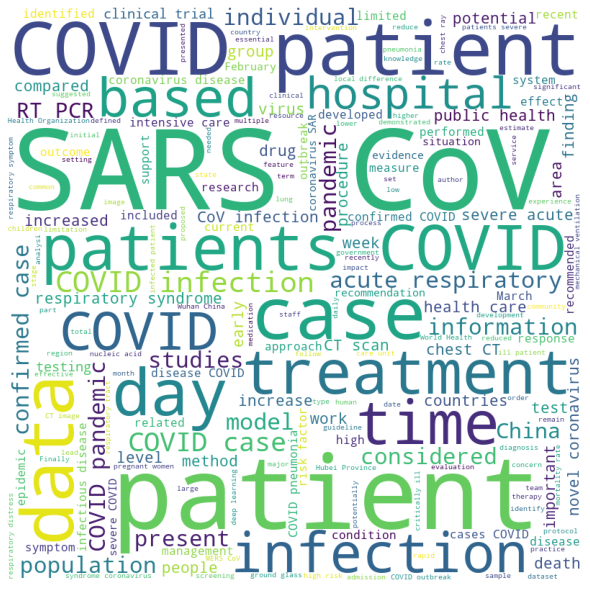

In [ ]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = clustering_specific_stopwords, 
                min_font_size = 10).generate(group_bodies[0])

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### Saving the Clustering Groups Visualizations

We save the rest of the results to a local folder. Please take a look at the images for a general idea of the topics found.

In [ ]:
mkdir text_clustering_word_clouds

In [ ]:
%%time
for index in np.arange(0, best_k):
    wordcloud = WordCloud(width = 1000, height = 1000, 
                    background_color ='white', 
                    stopwords = clustering_specific_stopwords, 
                    min_font_size = 10).generate(group_bodies[index])
    print(index, ' ', end="")
    wordcloud.to_file('text_clustering_word_clouds/group_' + str(index) + '.png')
print('')

0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  
CPU times: user 12min 37s, sys: 26.9 s, total: 13min 4s
Wall time: 13min 4s


In [ ]:
!zip -r text_clustering_word_clouds.zip text_clustering_word_clouds

  adding: text_clustering_word_clouds/ (stored 0%)
  adding: text_clustering_word_clouds/group_35.png (deflated 0%)
  adding: text_clustering_word_clouds/group_10.png (deflated 0%)
  adding: text_clustering_word_clouds/group_31.png (deflated 0%)
  adding: text_clustering_word_clouds/group_28.png (deflated 0%)
  adding: text_clustering_word_clouds/group_3.png (deflated 0%)
  adding: text_clustering_word_clouds/group_6.png (deflated 0%)
  adding: text_clustering_word_clouds/group_33.png (deflated 0%)
  adding: text_clustering_word_clouds/group_5.png (deflated 0%)
  adding: text_clustering_word_clouds/group_22.png (deflated 0%)
  adding: text_clustering_word_clouds/group_32.png (deflated 0%)
  adding: text_clustering_word_clouds/group_13.png (deflated 0%)
  adding: text_clustering_word_clouds/group_34.png (deflated 0%)
  adding: text_clustering_word_clouds/group_4.png (deflated 0%)
  adding: text_clustering_word_clouds/group_25.png (deflated 0%)
  adding: text_clustering_word_clouds/group

## Search Results

In this section, we use the classes and methods that we defined in this notebook to obtain some useful results concerning the task. <br>

### Query Definition
We start by defining the queries for the search and preprocessing them for usage.

In [ ]:
def get_processed_tokens(row, tokenizer, lemmatizer, custom_stopwords_set=stopwords.words('english')):

    data  = ' '.join([row['abstract'], row['body']])

    # tokenize the input
    tokens = tokenizer.tokenize(data)

    # convert case
    # remove stop words
    # lemmatize the input
    tokens = [
        lemmatizer.lemmatize(
            lemmatizer.lemmatize(
                token.lower(), 
                pos='v'
            ), 
            pos='n'
        ) 
        for token in tokens if token.lower() not in custom_stopwords_set
    ]

    # we have chosen not to perform other stemming to preserve gradations in meaning
    return tokens

In [ ]:
queries = [
    [
        'potential risks factors of covid',
        'smoking pre-existing pulmonary disease lungs'
    ],
    [
        'potential risks factors of covid',
        'co-infections coinfections co-existing coexisting respiratory viral infections virus transmissible transmission virulent co-morbidity comorbidity'
    ],
    [
        'potential risks factors of covid',
        'neonates pregnant women infants newborn'
    ],
    [
        'potential risks factors of covid',
        'socio-economic social behavior factors understand economic impact virus differences'
    ],
    [
        'covid transmission',
        'basic reproductive number r0 reproduce'
    ],
    [
        'transmission of covid',
        'incubation period'
    ],
    [
        'transmission of covid',
        'serial interval'
    ],
    [
        'transmission of covid',
        'modes of transmission ways of transmission '
    ],
    [
        'covid',
        'environmental environment climate weather pollution'
    ],
    [
        'severity disease covid',
        'risk fatality death symptomatic hospitalized patients'
    ],
    [
        'severity covid',
        'high-risk in danger'
    ],
    [
        'susceptibility populations covid',
        'susceptible population'
    ],
    [
        'public health covid',
        'mitigation measures effective control'
    ]
]

queries_df = pd.DataFrame(queries, columns = ['abstract', 'body'])
preprocessed_queries = queries_df.progress_apply(lambda row: get_processed_tokens(row, tokenizer, lemmatizer, expanded_stopwords_set), axis = 1)
queries_ready = to_sentence(preprocessed_queries)
print('\nQueries are ready!')


100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


Queries are ready!


### 1. Data on potential risks factors

 #### a. Smoking, pre-existing pulmonary disease

Query: potential risk factor covid smoke pre exist pulmonary disease lung
Top Results:



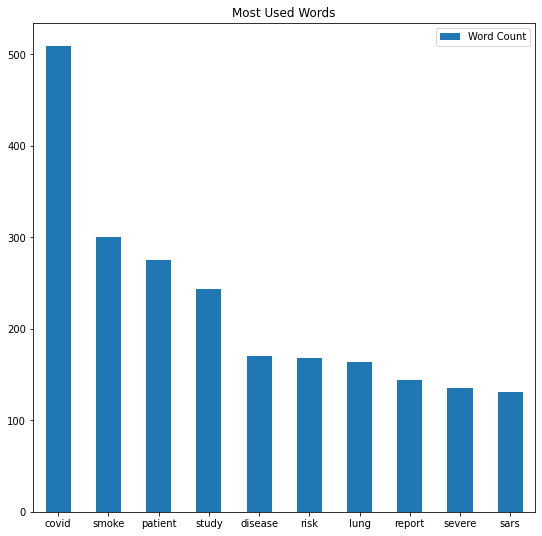

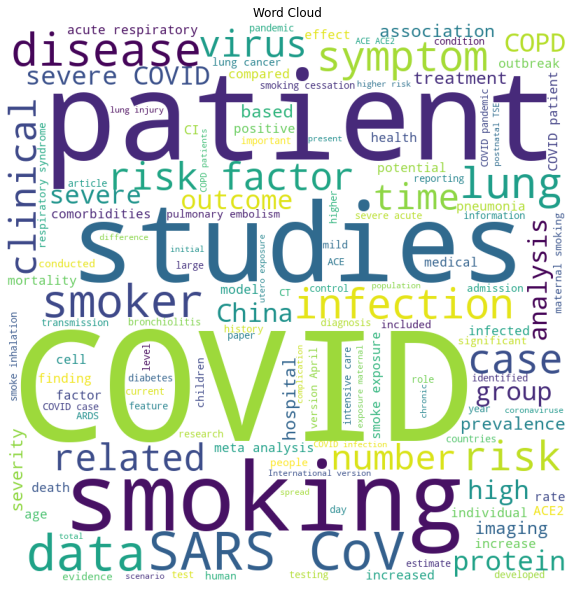

In [ ]:
tfidf_search.display_results(queries_ready[0], preprocessed_papers_df, papers_df)

#### b. Co-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities

Query: potential risk factor covid infection coinfections exist coexist respiratory viral infection virus transmissible transmission virulent morbidity comorbidity
Top Results:



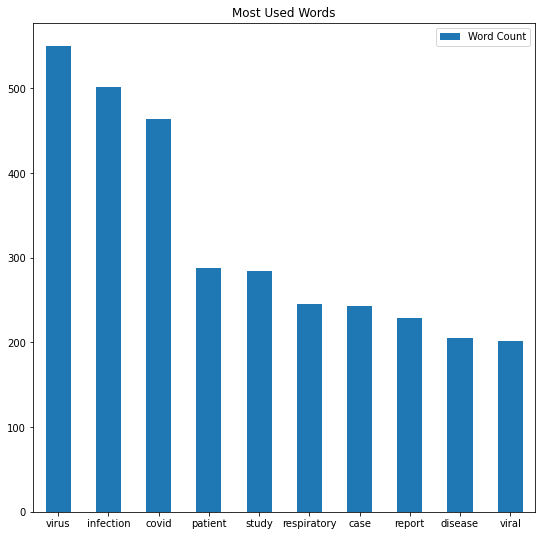

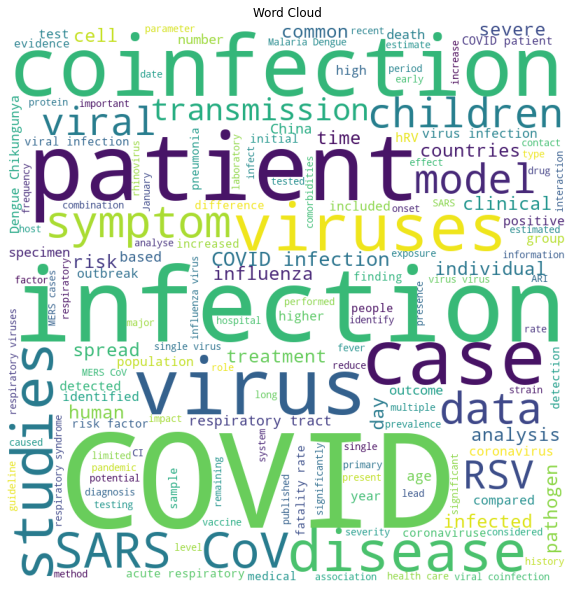

In [ ]:
tfidf_search.display_results(queries_ready[1], preprocessed_papers_df, papers_df)

#### c. Neonates and pregnant women

Query: potential risk factor covid neonate pregnant woman infant newborn
Top Results:



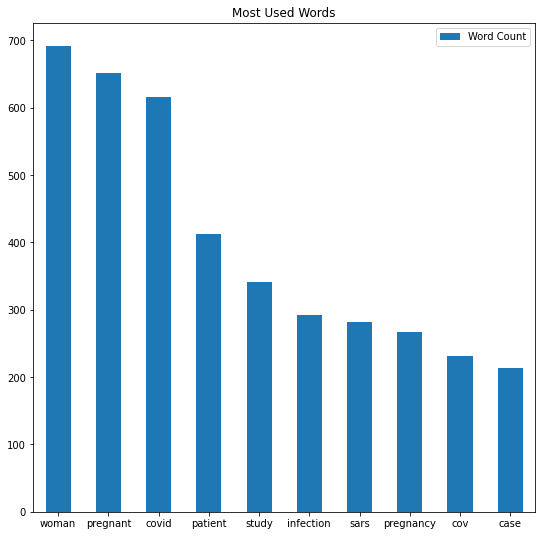

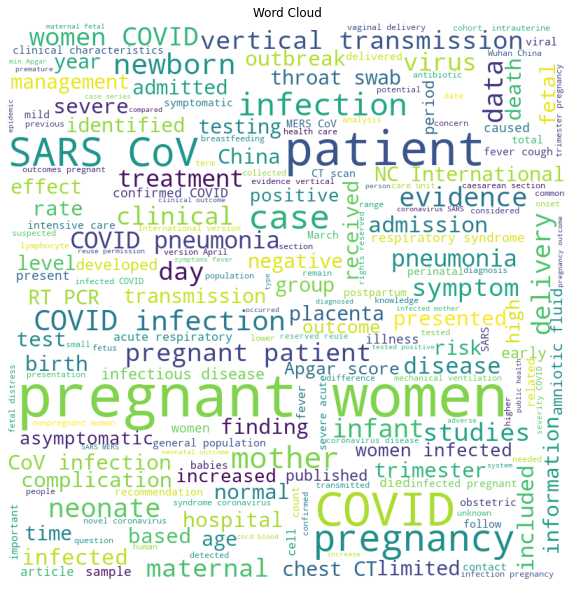

In [ ]:
tfidf_search.display_results(queries_ready[2], preprocessed_papers_df, papers_df)

 #### d. Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences.

Query: potential risk factor covid socio economic social behavior factor understand economic impact virus difference
Top Results:



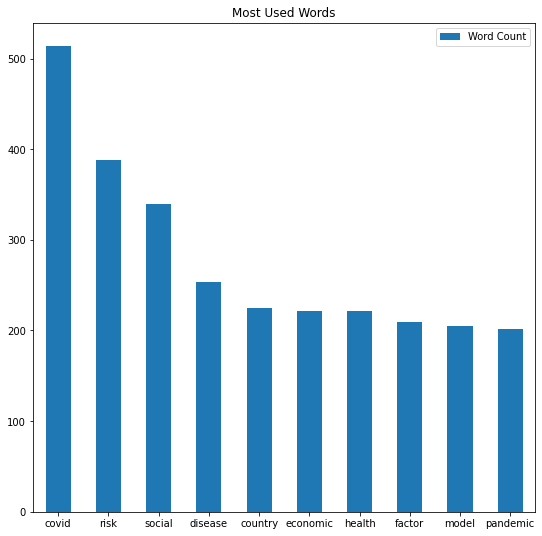

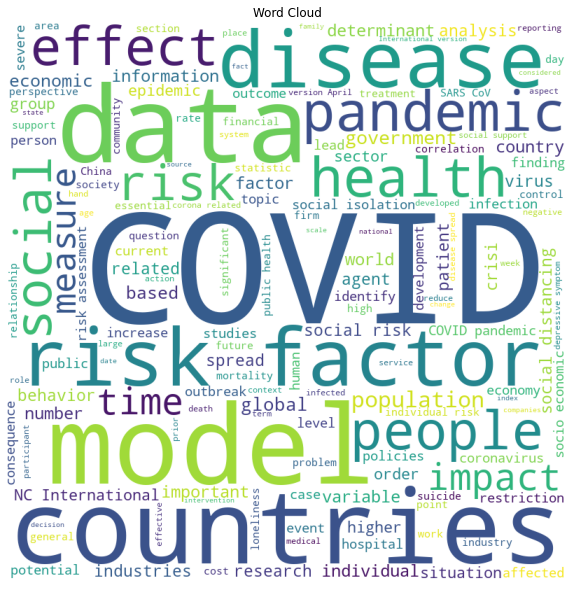

In [ ]:
tfidf_search.display_results(queries_ready[3], preprocessed_papers_df, papers_df)

### 2. Transmission Dynamics of the Virus

#### a. The Basic Reproductive Number

Query: covid transmission basic reproductive number r reproduce
Top Results:



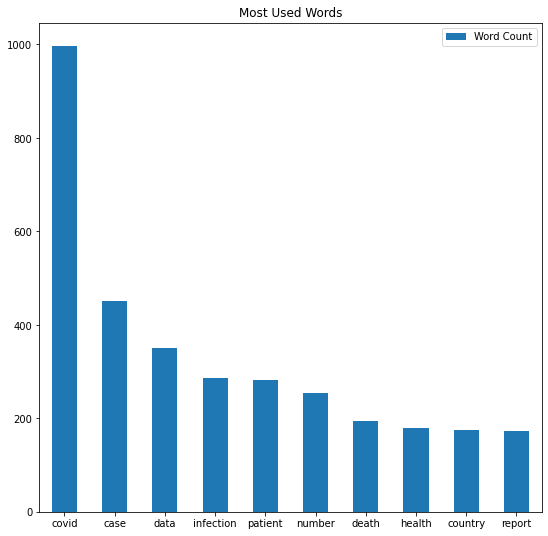

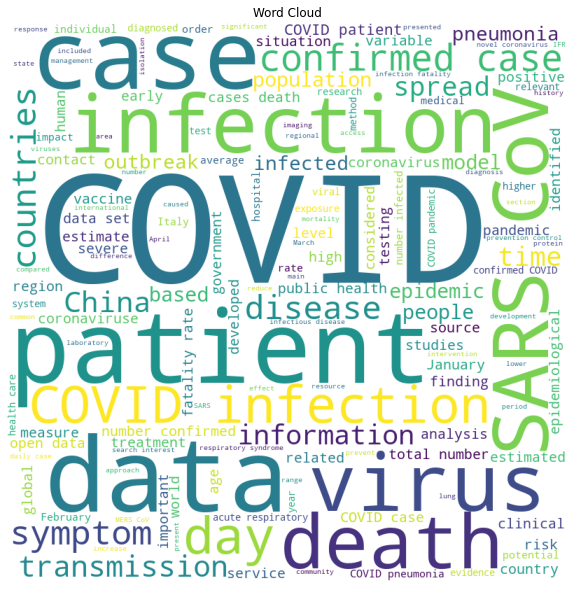

In [ ]:
tfidf_search.display_results(queries_ready[4], preprocessed_papers_df, papers_df)

#### b. The Incubation Period

Query: transmission covid incubation period
Top Results:



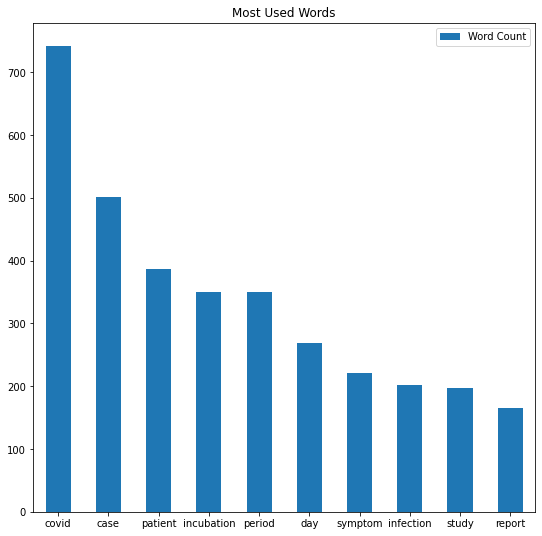

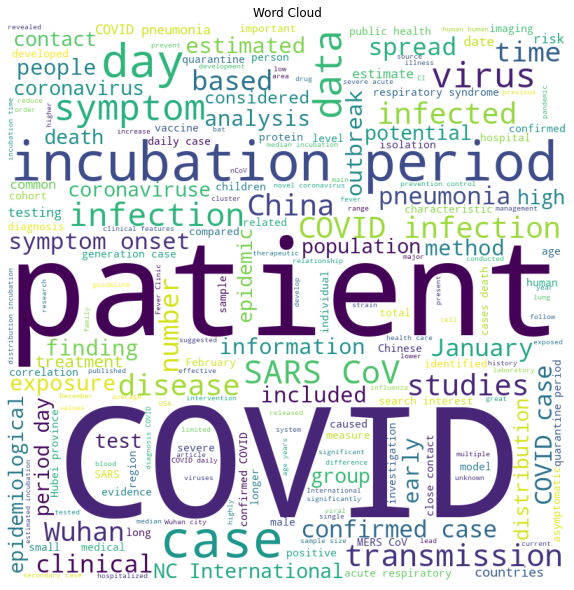

In [ ]:
tfidf_search.display_results(queries_ready[5], preprocessed_papers_df, papers_df)

#### c. Serial Interval

Query: transmission covid serial interval
Top Results:



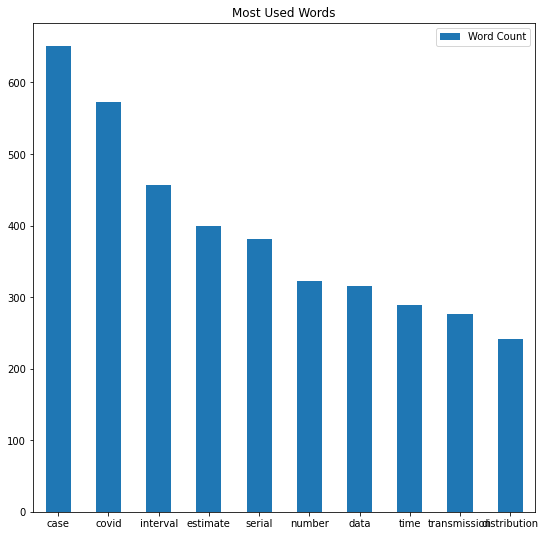

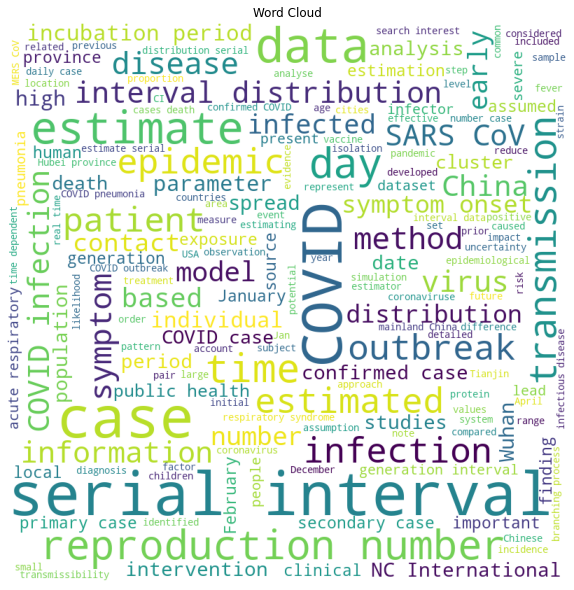

In [ ]:
tfidf_search.display_results(queries_ready[6], preprocessed_papers_df, papers_df)

#### d. Modes of Transmission

Query: transmission covid mode transmission way transmission
Top Results:



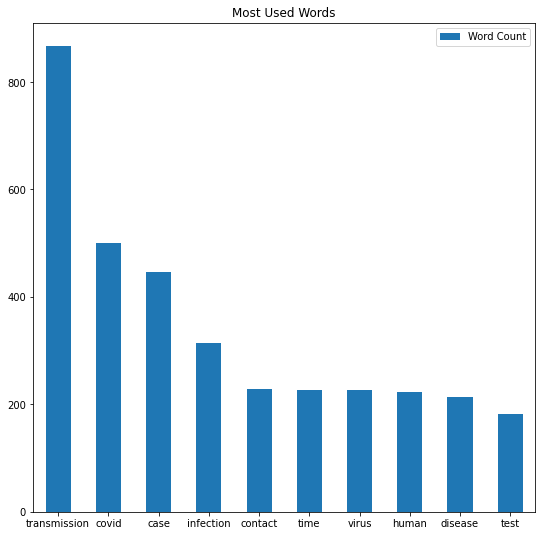

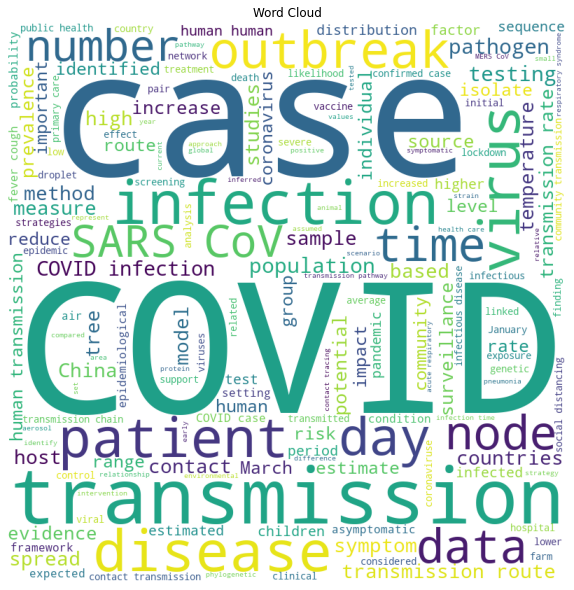

In [ ]:
tfidf_search.display_results(queries_ready[7], preprocessed_papers_df, papers_df)

#### e.  Environmental Factors

Query: covid environmental environment climate weather pollution
Top Results:



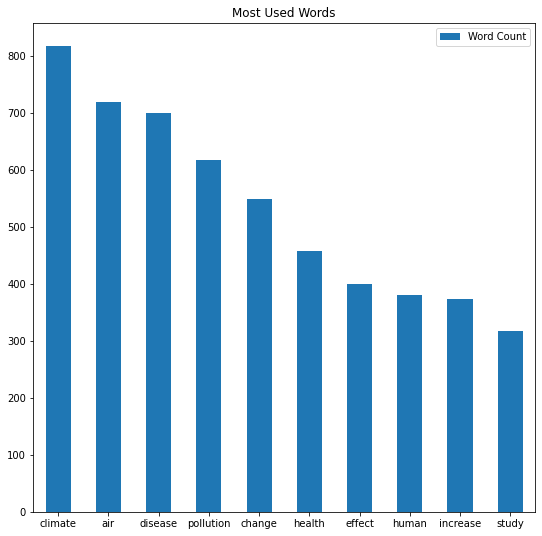

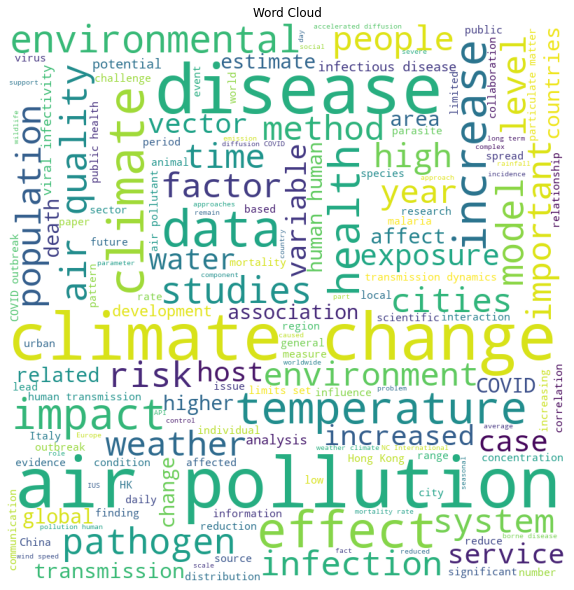

In [ ]:
tfidf_search.display_results(queries_ready[8], preprocessed_papers_df, papers_df)

### 3. Severity of Disease

#### a. Risk of fatality among Symptomatic Hospitalized Patients

Query: severity disease covid risk fatality death symptomatic hospitalize patient
Top Results:



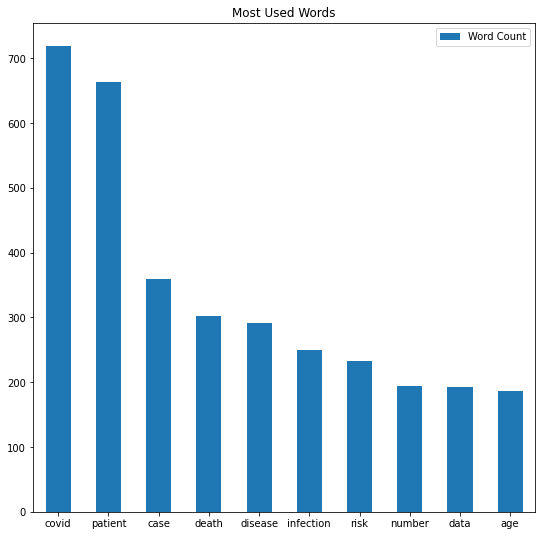

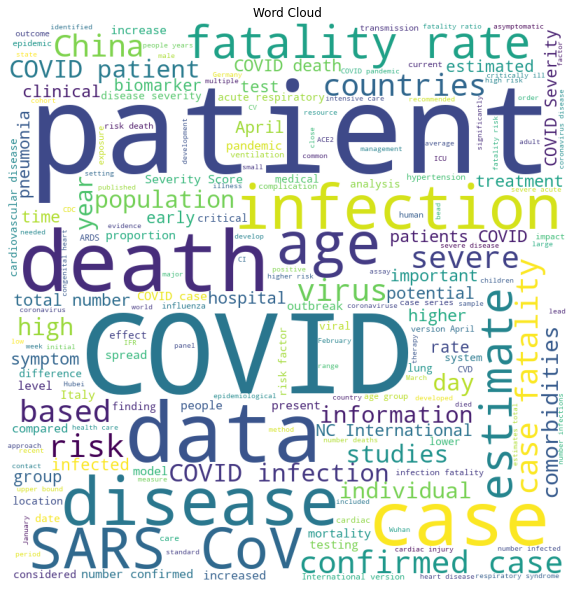

In [ ]:
tfidf_search.display_results(queries_ready[9], preprocessed_papers_df, papers_df)

#### b. High-risk Patient Groups

Query: severity covid high risk danger
Top Results:



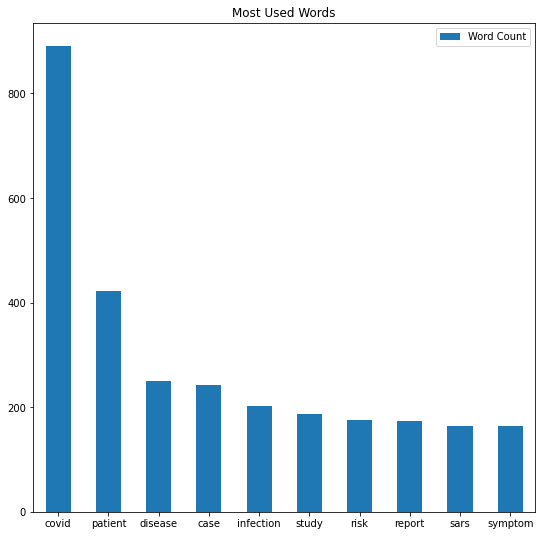

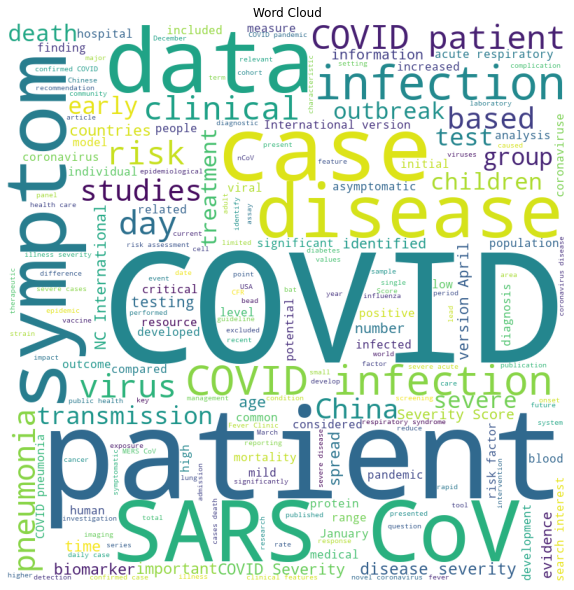

In [ ]:
tfidf_search.display_results(queries_ready[10], preprocessed_papers_df, papers_df)

### 4. Susceptibility of Populations

Query: susceptibility population covid susceptible population
Top Results:



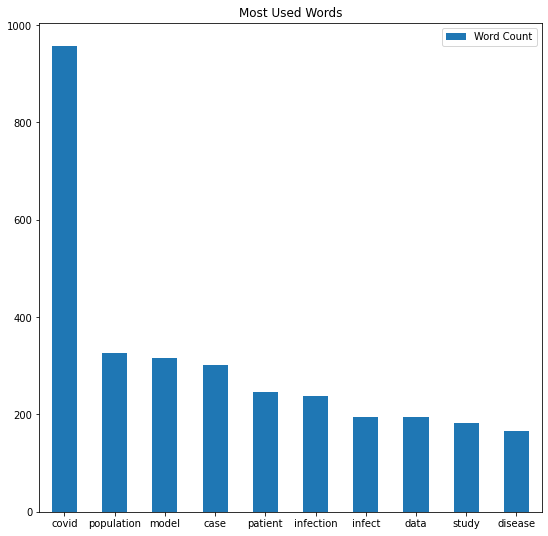

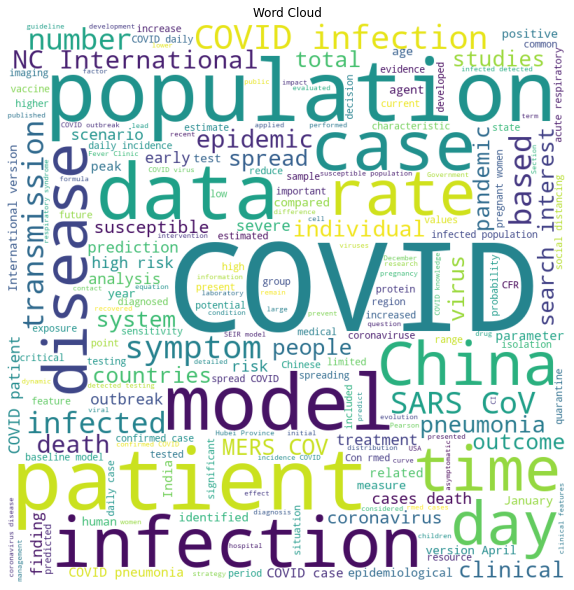

In [ ]:
tfidf_search.display_results(queries_ready[11], preprocessed_papers_df, papers_df)

### 5. Public health mitigation measures that could be effective for control

Query: public health covid mitigation measure effective control
Top Results:



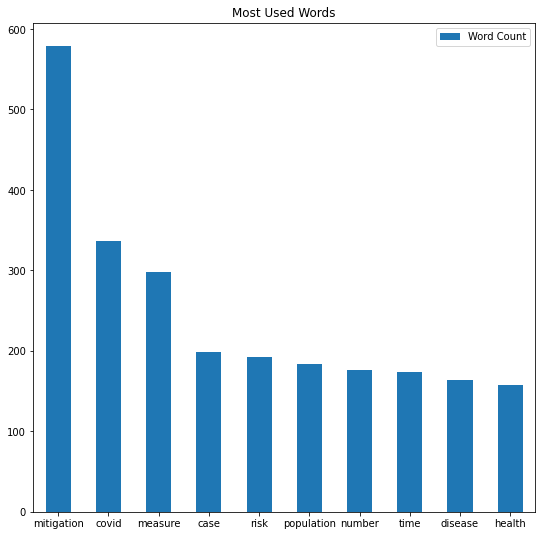

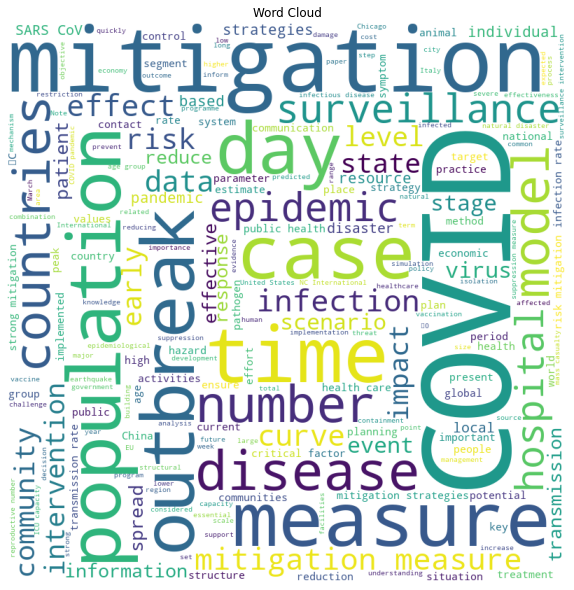

In [ ]:
tfidf_search.display_results(queries_ready[12], preprocessed_papers_df, papers_df)

## Ngrams Text Generation Results

In order to improve the search and explore more topics and themes related to a particular keyword, we can use the text generation model to refine queries or find new keywords. In this section, we generate text that could be used in the queries related to the task's topics.

### 1. Data on potential risks factors
 * Smoking, pre-existing pulmonary disease
 * Co-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities
 * Neonates and pregnant women
 * Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences.


In [ ]:
for i in range(15):
    print(generate_ngram_text('smoking', no_of_keywords=3))

['smoke', 'barrier', 'wall', '</s>']
['smoke', 'brake', '</s>', '</s>']
['smoke', 'cigarette', 'bidis', 'local']
['smoke', 'test', 'conduct', 'identify']
['smoke', 'expose', 'rat', '</s>']
['smoke', 'seldom', 'mention', 'clinical']
['smoke', 'cessation', 'intervention', 'offer']
['smoke', 'detail', 'implementation', 'adaptation']
['smoke', 'alcohol', 'abuse', 'toluene']
['smoke', 'status', '</s>', '</s>']
['smoke', '</s>', '</s>', '</s>']
['smoke', 'prevalent', 'habit', 'reflect']
['smoke', 'free', 'air', 'pleural']
['smoke', 'recognize', 'modifiable', 'risk']
['smoke', 'early', 'age', '</s>']


In [ ]:
for i in range(15):
    print(generate_ngram_text('pulmonary', no_of_keywords=3))

['pulmonary', 'capillary', 'permeability', 'accentuation']
['pulmonary', 'infiltrate', 'hospital', 'patient']
['pulmonary', 'disease', 'smoke', 'habit']
['pulmonary', 'patient', 'sample', 'occur']
['pulmonary', 'clinic', 'nonhospitalized', 'case']
['pulmonary', 'infiltrate', 'note', 'day']
['pulmonary', 'hypertension', 'corpulmonale', '</s>']
['pulmonary', 'valve', 'stenosis', '</s>']
['pulmonary', 'hypertension', '</s>', '</s>']
['pulmonary', 'cerebral', 'involvement', 'h5n1']
['pulmonary', 'artery', 'dilatation', 'appear']
['pulmonary', 'crepitation', 'oxygen', 'dependent']
['pulmonary', 'involvement', 'weil', 'syndrome']
['pulmonary', 'clinic', '</s>', '</s>']
['pulmonary', 'function', 'asthmatic', 'inflammation']


In [ ]:
for i in range(15):
    print(generate_ngram_text('respiratory infection', no_of_keywords=3))

['respiratory', 'infection', 'complexity', 'bacterial', 'lifestyle']
['respiratory', 'infection', 'demonstrate', 'animal', 'vaccinate']
['respiratory', 'infection', 'sneeze', 'nasal', 'discharge']
['respiratory', 'infection', 'control', 'continue', 'exercise']
['respiratory', 'infection', 'prevent', 'complication', 'tuberculous']
['respiratory', 'infection', 'correlate', 'increase', 'case']
['respiratory', 'infection', 'develop', 'disease', '</s>']
['respiratory', 'infection', '</s>', '</s>', '</s>']
['respiratory', 'infection', '</s>', '</s>', '</s>']
['respiratory', 'infection', 'group', 'survival', 'rate']
['respiratory', 'infection', 'health', 'care', 'worker']
['respiratory', 'infection', 'covid', 'patient', 'start']
['respiratory', 'infection', 'reactivation', 'epstein', 'barr']
['respiratory', 'infection', 'poultry', 'country', '</s>']
['respiratory', 'infection', 'pneumonia', 'recover', 'week']


In [ ]:
for i in range(15):
    print(generate_ngram_text('morbiditiy', no_of_keywords=3))

['morbiditiy', 'mortality', 'rat', 'age']
['morbiditiy', 'mortality', 'rat', 'reflect']
['morbiditiy', 'additional', 'healthcare', 'worker']
['morbiditiy', 'additional', 'healthcare', 'utilization']
['morbiditiy', 'additional', 'healthcare', 'contact']
['morbiditiy', 'mortality', 'rat', 'afb']
['morbiditiy', 'additional', 'healthcare', 'worker']
['morbiditiy', 'mortality', 'rat', 'patient']
['morbiditiy', 'additional', 'healthcare', 'worker']
['morbiditiy', 'additional', 'healthcare', 'worker']
['morbiditiy', 'additional', 'healthcare', 'worker']
['morbiditiy', 'mortality', 'rat', 'respiratory']
['morbiditiy', 'additional', 'healthcare', 'worker']
['morbiditiy', 'mortality', 'rat', 'successfully']
['morbiditiy', 'additional', 'healthcare', 'worker']


In [ ]:
for i in range(15):
    print(generate_ngram_text('neonates', no_of_keywords=3))

['neonate', 'maternal', 'infection', 'gestation']
['neonate', 'mild', 'illness', 'child']
['neonate', 'structure', 'superficial', 'regard']
['neonate', 'adult', '</s>', '</s>']
['neonate', '</s>', '</s>', '</s>']
['neonate', 'immunoglobulin', 'outbreak', 'intervention']
['neonate', 'dog', 'older', 'year']
['neonate', 'fig', '</s>', '</s>']
['neonate', 'develop', 'intranuclear', 'cytoplasmic']
['neonate', 'crucial', 'success', 'global']
['neonate', '</s>', '</s>', '</s>']
['neonate', 'weigh', 'birth', '</s>']
['neonate', 'puppy', 'kitten', 'normal']
['neonate', 'infant', 'mortality', '</s>']
['neonate', 'evaluate', 'late', 'death']


In [ ]:
for i in range(15):
    print(generate_ngram_text('pregnant woman', no_of_keywords=3))

['pregnant', 'woman', 'record', 'malaria', 'history']
['pregnant', 'woman', 'immunocompromised', 'individual', 'immunocompromised']
['pregnant', 'woman', 'higher', 'level', 'antigen']
['pregnant', 'woman', 'influenza', 'infection', '</s>']
['pregnant', 'woman', 'trimester', 'pregnancy', 'initial']
['pregnant', 'woman', 'blood', 'donor', 'education']
['pregnant', 'woman', 'significant', 'factor', 'predict']
['pregnant', 'woman', '</s>', '</s>', '</s>']
['pregnant', 'woman', '</s>', '</s>', '</s>']
['pregnant', 'woman', '</s>', '</s>', '</s>']
['pregnant', 'woman', 'newborn', 'family', 'member']
['pregnant', 'woman', 'control', 'sexual', 'preference']
['pregnant', 'woman', 'transmit', 'hiv', '</s>']
['pregnant', 'woman', 'fetus', 'attempt', 'study']
['pregnant', 'woman', 'preterm', 'delivery', 'justify']


In [ ]:
for i in range(15):
    print(generate_ngram_text('mother risk', no_of_keywords=3))

['mother', 'risk', 'sleep', 'apnea', 'syndrome']
['mother', 'risk', 'wheeze', 'lower', 'respiratory']
['mother', 'risk', 'hemolytic', 'streptococcal', 'specie']
['mother', 'risk', 'infant', 'year', 'age']
['mother', 'risk', 'infection', 'control', 'viral']
['mother', 'risk', 'infection', 'suggest', 'systemic']
['mother', 'risk', 'infection', 'affect', 'school']
['mother', 'risk', 'infection', 'recipient', 'survive']
['mother', 'risk', 'infect', 'hrv', 'serotypes']
['mother', 'risk', 'fulminant', 'hepatitis', 'patient']
['mother', 'risk', 'infection', 'high', 'moderate']
['mother', 'risk', 'hiv', 'transmission', 'cervical']
['mother', 'risk', '</s>', '</s>', '</s>']
['mother', 'risk', 'congenital', 'malformation', 'berrill']
['mother', 'risk', 'hiv', 'infection', 'autophagy']


In [ ]:
for i in range(15):
    print(generate_ngram_text('socio-economic', no_of_keywords=3))

['socio', 'economic', 'factor', 'depletion', 'replication']
['socio', 'economic', 'distress', '</s>', '</s>']
['socio', 'economic', 'cost', '</s>', '</s>']
['socio', 'economic', 'factor', 'create', 'statistical']
['socio', 'economic', 'index', 'area', 'seifa']
['socio', 'economic', 'politico', 'institutional', 'sea']
['socio', 'economic', 'disruption', '</s>', '</s>']
['socio', 'economic', 'factor', 'analyse', 'strong']
['socio', 'economic', 'dynamic', '</s>', '</s>']
['socio', 'economic', 'difference', 'develop', 'clinical']
['socio', 'economic', 'region', '</s>', '</s>']
['socio', 'economic', 'driver', 'disease', '</s>']
['socio', 'economic', 'impact', '</s>', '</s>']
['socio', 'economic', 'disparity', 'rich', 'poor']
['socio', 'economic', 'factor', '</s>', '</s>']


In [ ]:
for i in range(15):
    print(generate_ngram_text('behavioral difference', no_of_keywords=3))

['behavioral', 'difference', '</s>', '</s>', '</s>']
['behavioral', 'difference', 'role', 'translation', 'localization']
['behavioral', 'difference', 'resident', 'transient', '</s>']
['behavioral', 'difference', 'kennel', 'possibly', 'low']
['behavioral', 'difference', 'human', 'isolate', 'glycine']
['behavioral', 'difference', 'role', 'cysteine', 'residue']
['behavioral', 'difference', '</s>', '</s>', '</s>']
['behavioral', 'difference', '</s>', '</s>', '</s>']
['behavioral', 'difference', 'human', 'animal', 'herpesvirus']
['behavioral', 'difference', 'specie', 'calculate', 'codon']
['behavioral', 'difference', 'ilp', 'expression', 'pattern']
['behavioral', 'difference', '</s>', '</s>', '</s>']
['behavioral', 'difference', 'compare', 'homologues', 'predict']
['behavioral', 'difference', 'fig', '</s>', '</s>']
['behavioral', 'difference', 'social', 'network', 'important']


In [ ]:
for i in range(15):
    print(generate_ngram_text('economic impact', no_of_keywords=3))

['economic', 'impact', '</s>', '</s>', '</s>']
['economic', 'impact', 'ensue', 'disease', 'burden']
['economic', 'impact', 'business', 'interruption', 'insurance']
['economic', 'impact', 'early', 'covid', 'outbreak']
['economic', 'impact', 'loss', 'antibody', 'case']
['economic', 'impact', '</s>', '</s>', '</s>']
['economic', 'impact', 'climate', 'change', 'damage']
['economic', 'impact', 'virus', 'evolution', 'framework']
['economic', 'impact', 'state', 'wide', 'devil']
['economic', 'impact', 'sars', 'international', 'travel']
['economic', 'impact', 'brd', 'national', 'scale']
['economic', 'impact', 'peter', 'public', 'panic']
['economic', 'impact', '</s>', '</s>', '</s>']
['economic', 'impact', 'future', 'event', '</s>']
['economic', 'impact', 'resistant', 'enclosure', 'egress']


### 2. Transmission dynamics of the virus
* the basic reproductive number
* incubation period
* serial interval
* modes of transmission 
* environmental factors

In [ ]:
for i in range(15):
    print(generate_ngram_text('reproductive number', no_of_keywords=3))

['reproductive', 'number', 'current', 'recover', '</s>']
['reproductive', 'number', 'hfmd', 'pathogen', 'spectrum']
['reproductive', 'number', 'greater', 'italy', 'iran']
['reproductive', 'number', 'suggest', 'hbov', 'detection']
['reproductive', 'number', 'threshold', 'parameter', 'epidemic']
['reproductive', 'number', 'expect', 'test', 'set']
['reproductive', 'number', 'network', 'measure', 'centrality']
['reproductive', 'number', 'fit', 'parameter', 'function']
['reproductive', 'number', 'simply', 'eðvþdðu', 'anderson']
['reproductive', 'number', 'model', 'propose', 'good']
['reproductive', 'number', 'rely', 'pre', 'establish']
['reproductive', 'number', 'greater', 'equal', 'time']
['reproductive', 'number', '</s>', '</s>', '</s>']
['reproductive', 'number', 'effect', 'glycosylation', 'removal']
['reproductive', 'number', 'fit', 'coefficient', 'level']


In [ ]:
for i in range(15):
    print(generate_ngram_text('incubation period', no_of_keywords=3))

['incubation', 'period', 'approximately', 'month', '</s>']
['incubation', 'period', 'time', 'quality', 'life']
['incubation', 'period', 'illness', 'interval', 'day']
['incubation', 'period', 'timewise', 'follow', 'site']
['incubation', 'period', 'liquid', 'waste', 'option']
['incubation', 'period', 'rotavirus', 'difference', 'outcome']
['incubation', 'period', '</s>', '</s>', '</s>']
['incubation', 'period', '</s>', '</s>', '</s>']
['incubation', 'period', 'fig', '</s>', '</s>']
['incubation', 'period', 'commonly', 'accept', 'work']
['incubation', 'period', 'day', 'longer', 'weekend']
['incubation', 'period', 'human', 'circulation', '</s>']
['incubation', 'period', 'distribution', 'estimate', 'hospitalisation']
['incubation', 'period', 'day', '</s>', '</s>']
['incubation', 'period', 'determine', '</s>', '</s>']


In [ ]:
for i in range(15):
    print(generate_ngram_text('serial interval', no_of_keywords=3))

['serial', 'interval', 'play', 'key', 'role']
['serial', 'interval', 'probable', 'case', 'locate']
['serial', 'interval', 'time', '</s>', '</s>']
['serial', 'interval', 'day', 'estimate', 'infection']
['serial', 'interval', '</s>', '</s>', '</s>']
['serial', 'interval', '</s>', '</s>', '</s>']
['serial', 'interval', 'distribution', 'definition', 'extend']
['serial', 'interval', 'distribution', 'estimate', 'observe']
['serial', 'interval', 'ncov', 'sars', 'cov']
['serial', 'interval', 'distribution', 'day', 'standard']
['serial', 'interval', 'shorter', 'survival', 'time']
['serial', 'interval', 'distribution', '</s>', '</s>']
['serial', 'interval', 'distribution', 'slightly', 'higher']
['serial', 'interval', 'estimate', 'worthwhile', 'point']
['serial', 'interval', 'small', 'period', 'time']


In [ ]:
for i in range(15):
    print(generate_ngram_text('transmission', no_of_keywords=3))

['transmission', 'malaria', 'mosquito', 'bear']
['transmission', 'protect', 'personnel', 'work']
['transmission', 'occur', 'urban', 'environment']
['transmission', 'asymptomatic', 'contact', 'shorten']
['transmission', 'dynamic', 'depend', 'strongly']
['transmission', '</s>', '</s>', '</s>']
['transmission', '</s>', '</s>', '</s>']
['transmission', 'elucidate', 'mers', '</s>']
['transmission', 'ability', 'virus', 'fusion']
['transmission', 'allergic', 'reaction', 'section']
['transmission', 'electron', 'microscopy', 'dem']
['transmission', 'dynamic', 'single', 'molecule']
['transmission', '</s>', '</s>', '</s>']
['transmission', 'rate', '</s>', '</s>']
['transmission', '</s>', '</s>', '</s>']


In [ ]:
for i in range(15):
    print(generate_ngram_text('environment', no_of_keywords=3))

['environment', '</s>', '</s>', '</s>']
['environment', 'plan', 'namilae', 'cruise']
['environment', 'appear', 'presence', 'viral']
['environment', 'low', 'financial', 'constraint']
['environment', 'affect', 'urban', 'area']
['environment', 'consequence', 'weather', 'low']
['environment', 'vector', 'water', 'vapor']
['environment', 'urban', 'region', 'composition']
['environment', 'human', 'health', 'environment']
['environment', '</s>', '</s>', '</s>']
['environment', '</s>', '</s>', '</s>']
['environment', 'selectively', 'inhibit', 'meet']
['environment', 'time', 'physical', 'activity']
['environment', 'condition', '</s>', '</s>']
['environment', 'accept', 'electron', 'reduce']


In [ ]:
for i in range(15):
    print(generate_ngram_text('climate', no_of_keywords=3))

['climate', 'change', 'emerge', 'pathogen']
['climate', 'bird', 'type', 'bornavirus']
['climate', 'change', 'improve', 'public']
['climate', '</s>', '</s>', '</s>']
['climate', 'change', 'asian', 'financial']
['climate', 'change', 'increase', 'likelihood']
['climate', 'variable', 'influenza', 'virus']
['climate', 'metropolitan', 'area', 'link']
['climate', 'gather', 'katowice', 'poland']
['climate', 'urban', 'climate', 'past']
['climate', 'change', 'include', 'heat']
['climate', 'change', 'signal', 'observation']
['climate', 'suggest', 'inevitable', 'extend']
['climate', 'change', '</s>', '</s>']
['climate', 'change', 'cross', 'strait']


### 3. Severity of disease
* risk of fatality among symptomatic hospitalized patients
* high-risk patient groups

In [ ]:
for i in range(15):
    print(generate_ngram_text('hospitalized patient', no_of_keywords=3))

['hospitalize', 'patient', 'pneumonia', 'provide', 'supplemental']
['hospitalize', 'patient', '</s>', '</s>', '</s>']
['hospitalize', 'patient', 'child', 'adult', 'degree']
['hospitalize', 'patient', 'sars', '</s>', '</s>']
['hospitalize', 'patient', 'current', 'health', 'status']
['hospitalize', 'patient', 'pneumonia', 'city', 'wuhan']
['hospitalize', 'patient', 'infectious', 'respiratory', 'secretion']
['hospitalize', 'patient', 'develop', 'persistent', 'infection']
['hospitalize', 'patient', 'emerge', 'infectious', 'disease']
['hospitalize', 'patient', 'careful', 'image', 'obstruct']
['hospitalize', 'patient', 'test', '</s>', '</s>']
['hospitalize', 'patient', 'contaminate', 'hand', 'surface']
['hospitalize', 'patient', 'investigate', 'protection', 'endanger']
['hospitalize', 'patient', 'greater', 'surface', 'area']
['hospitalize', 'patient', '</s>', '</s>', '</s>']


In [ ]:
for i in range(15):
    print(generate_ngram_text('covid fatality', no_of_keywords=3))

['covid', 'fatality', 'israel', '</s>', '</s>']
['covid', 'fatality', 'speed', 'expect', 'time']
['covid', 'fatality', 'world', 'health', 'organization']
['covid', 'fatality', 'set', '</s>', '</s>']
['covid', 'fatality', 'start', 'date', 'patient']
['covid', 'fatality', 'rat', 'variable', 'single']
['covid', 'fatality', 'rat', '</s>', '</s>']
['covid', 'fatality', 'divide', 'total', 'flowrate']
['covid', 'fatality', 'rate', '</s>', '</s>']
['covid', 'fatality', 'lombardy', 'region', 'overwhelm']
['covid', 'fatality', 'rat', 'influenza', 'infection']
['covid', 'fatality', 'risk', 'human', 'population']
['covid', 'fatality', 'rat', 'tend', 'decline']
['covid', 'fatality', 'rate', '</s>', '</s>']
['covid', 'fatality', 'lombardy', 'region', '</s>']


In [ ]:
for i in range(15):
    print(generate_ngram_text('high-risk', no_of_keywords=3))

['high', 'risk', 'resistance', '</s>', '</s>']
['high', 'risk', 'patient', 'adverse', 'effect']
['high', 'risk', 'novel', 'statistical', 'method']
['high', 'risk', 'cutaneous', 'visceral', 'form']
['high', 'risk', 'location', 'visit', 'vary']
['high', 'risk', 'group', '</s>', '</s>']
['high', 'risk', 'veterinarian', 'farmer', 'part']
['high', 'risk', 'individual', 'meet', 'criterion']
['high', 'risk', 'area', 'country', 'reach']
['high', 'risk', 'individual', 'respiratory', 'illness']
['high', 'risk', 'exposure', 'cytomegalovirus', 'herpes']
['high', 'risk', 'wild', 'ape', 'population']
['high', 'risk', 'high', 'infection', 'risk']
['high', 'risk', 'dialysis', 'technique', 'provide']
['high', 'risk', 'severe', 'acute', 'respiratory']


### 4. Susceptibility of populations

In [ ]:
for i in range(15):
    print(generate_ngram_text('susceptible', no_of_keywords=3))

['susceptible', '</s>', '</s>', '</s>']
['susceptible', 'coronavirus', 'madin', 'darby']
['susceptible', 'filovirus', 'virus', 'family']
['susceptible', 'early', 'generation', 'fxiii']
['susceptible', 'prv', 'infect', 'cell']
['susceptible', 'mouse', 'small', 'dose']
['susceptible', 'bovine', 'tuberculosis', 'brucellosis']
['susceptible', 'infectious', 'disease', 'ward']
['susceptible', 'infect', 'symptomatictreated', 'recover']
['susceptible', 'week', 'age', 'omphalophlebitis']
['susceptible', '</s>', '</s>', '</s>']
['susceptible', 'pertussis', 'approximately', 'year']
['susceptible', 'citronella', 'eucalyptus', 'scot']
['susceptible', '</s>', '</s>', '</s>']
['susceptible', 'infect', 'remove', 'protective']


In [ ]:
for i in range(15):
    print(generate_ngram_text('population', no_of_keywords=3))

['population', 'base', 'study', 'hrp']
['population', 'cell', 'lamellar', 'body']
['population', 'potential', 'risk', 'invasive']
['population', 'estimate', 'thailand', 'kenya']
['population', 'elucidate', 'coinfection', 'study']
['population', 'patient', 'chronic', 'hepatitis']
['population', '</s>', '</s>', '</s>']
['population', 'depend', 'current', 'value']
['population', 'covid', 'case', 'rely']
['population', 'kilometer', 'downwind', 'people']
['population', 'preexist', 'immunity', 'preclinical']
['population', 'allelic', 'frequency', 'differ']
['population', 'age', 'group', 'female']
['population', 'quasispecies', '</s>', '</s>']
['population', 'present', 'main', 'theorem']


In [ ]:
for i in range(15):
    print(generate_ngram_text('susceptible population', no_of_keywords=3))

['susceptible', 'population', '</s>', '</s>', '</s>']
['susceptible', 'population', 'european', 'country', 'show']
['susceptible', 'population', 'assume', 'slightly', 'modifiable']
['susceptible', 'population', 'presence', 'antiastrovirus', 'antibody']
['susceptible', 'population', 'infect', 'proportional', 'fraction']
['susceptible', 'population', '</s>', '</s>', '</s>']
['susceptible', 'population', '</s>', '</s>', '</s>']
['susceptible', 'population', '</s>', '</s>', '</s>']
['susceptible', 'population', '</s>', '</s>', '</s>']
['susceptible', 'population', 'fig', '</s>', '</s>']
['susceptible', 'population', 'keel', 'rohani', 'lloyd']
['susceptible', 'population', 'decrease', 'infection', 'window']
['susceptible', 'population', '</s>', '</s>', '</s>']
['susceptible', 'population', 'smaller', 'colon', 'stomach']
['susceptible', 'population', 'stop', 'vaccinate', '</s>']


### 5. Public health mitigation measures that could be effective for control

In [ ]:
for i in range(15):
    print(generate_ngram_text('public health', no_of_keywords=3))

['public', 'health', 'include', 'energy', 'industry']
['public', 'health', 'infrastructure', 'iraq', '</s>']
['public', 'health', 'official', 'epidemiologist', 'technician']
['public', 'health', 'concern', '</s>', '</s>']
['public', 'health', 'official', 'decision', '</s>']
['public', 'health', 'response', 'tcdc', 'laboratory']
['public', 'health', 'veterinarian', 'apply', 'competitive']
['public', 'health', 'surveillance', 'health', 'official']
['public', 'health', 'important', 'ass', 'spread']
['public', 'health', 'preparedness', '</s>', '</s>']
['public', 'health', 'official', 'chlorine', 'dioxide']
['public', 'health', 'threat', '</s>', '</s>']
['public', 'health', 'campaign', 'include', 'empty']
['public', 'health', 'division', 'national', 'health']
['public', 'health', 'emergency', '</s>', '</s>']


In [ ]:
for i in range(15):
    print(generate_ngram_text('effective control', no_of_keywords=3))

['effective', 'control', 'chinese', 'han', 'population']
['effective', 'control', 'prevention', 'government', 'allocate']
['effective', 'control', 'infection', '</s>', '</s>']
['effective', 'control', 'disease', 'generally', 'fall']
['effective', 'control', 'measure', '</s>', '</s>']
['effective', 'control', 'sessile', 'microorganism', '</s>']
['effective', 'control', 'calf', 'particle', 'concentrate']
['effective', 'control', 'measure', 'implement', 'world']
['effective', 'control', 'intervention', 'reduce', 'misinformation']
['effective', 'control', 'measure', 'include', 'frequency']
['effective', 'control', 'spread', 'contact', 'network']
['effective', 'control', 'achieve', 'sign', 'pain']
['effective', 'control', 'pathogen', 'increasingly', 'complicate']
['effective', 'control', 'endemic', 'zoonotic', 'disease']
['effective', 'control', 'nasal', 'aminopeptidase', 'secretion']


In [ ]:
for i in range(15):
    print(generate_ngram_text('mitigation', no_of_keywords=3))

['mitigation', 'reduce', 'illness', 'duration']
['mitigation', 'health', 'resource', 'asia']
['mitigation', 'option', 'exist', 'facemasks']
['mitigation', 'measure', 'prevent', 'pcv3']
['mitigation', 'objective', 'revert', 'sustain']
['mitigation', 'measure', 'low', 'dose']
['mitigation', 'acute', 'disease', 'exacerbation']
['mitigation', 'risk', 'ovarian', 'reserve']
['mitigation', 'phase', 'critical', 'order']
['mitigation', 'stage', '</s>', '</s>']
['mitigation', 'scenario', 'mitigation', 'healthcare']
['mitigation', '</s>', '</s>', '</s>']
['mitigation', 'special', 'risk', 'entail']
['mitigation', 'strategy', 'reduce', 'risk']
['mitigation', 'effort', 'plan', 'process']


## Clustering Results

Clustering results may vary from one run to the other, especially since the dataset is updated constantly. From our run, we discovered clusters related to the following themes:

1. Bats.
2. Dogs and Cats.
3. Horses.
4. SARS Cov and Covid.
5. SARS Cov in Hong Kong.
6. Genes and Amino Acids.
7. Data, Estimates, and Reproduction Number.
8. RT PCR.
9. SARS Cov and RNA Synthesis.
10. MERS Cov in Saudi Arabia.
11. Respiratory Tract and Risk Factors.
12. SARS Cov.
13. Peptides, Epitopes, Proteins, and Amino Acids.
14. Host Cells and Infected Cells.
15. RT LAMP.
16. Immune Response and Vaccination.
17. Immune Reponse, CD8 Cells, and CD4 Cells.
18. Hospitals, Health care, and infection control.
19. Public health and infectious diseases.
20. Treatment.
21. IBV.
22. Cattle and Calves.
23. PEDV.
24. TGEV.
25. Respiratory Infections and Viruses.
26. MHV.
27. Ang II.
28. ZIKV Infections.
29. siRNA, miRNA, and RNAi.
30. PRRSV.
31. Influenza, Avian Influenza, and H1N1.

The cell below displays the clustering groups as word clouds. Please check the output folder for the images.

In [ ]:
try:
    best_k
except:
    best_k = 36  # our result

fig = plt.figure(figsize=(100,100))

for index in np.arange(1, best_k + 1):
    img = plt.imread('text_clustering_word_clouds/group_' + str(index - 1) + '.png')
    a = fig.add_subplot(6, 6, index)
    imgplot = plt.imshow(img)

## Pros and Cons of the Approach

Our approach had the following pros:
* The search is capable of retrieving relevant, ranked results.
* The text clustering provides groups with meaningful themes
* The Ngram model provides some relevant terms that can be used to refine searches

Our approach had the following cons:
* Titles are not used.
* In the search, the occurrences of the terms in the title, abstract, and body is not weighted. For example, if a search word occurs in the title, the paper is more likely to be relevant.
* In the search, we use a bag-of-words approach; therefore, the co-occurrence of words is not represented effectively.
* The Ngram model is not as useful as had been expected.

## Future Recommendations

1. Clustering-group-specific search can be tested to obtain results within a certain theme.
2. Positional Indices can be tested for phrase queries.
3. Using the Ngrams generated keywords in searches.
4. Evaluating the relevance of the search results using some metrics (which may require the labeling of the dataset).